In [12]:
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import nibabel as nib
from scipy import ndimage
import glob
import sys,os
from natsort import natsorted
import tensorflow_probability as tfp
import random

%matplotlib inline

In [2]:
def read_nifti_file(filepath, min_num_sequence):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()[:,:,:,0:min_num_sequence]
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = 0
    max =   400 #Check this with Richard or Roland
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def normalize_aif(aif):
    normalized_aif = aif/np.max(aif)
    return normalized_aif

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


# Custom Loss Function
def MaxCorrelation(y_true,y_pred):
    """
    Goal is to maximize correlation between y_pred, y_true. Same as minimizing the negative.
    """
    return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))


In [57]:
tfp.stats.correlation??

In [13]:
#Reading Arterial Input Functions and Venous Output Functions from the annotations file and
#the corresponding coxels in the ISLES18 dataset

root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training/'
aif_annotations_path = '/home/sebastian/experiments/aifnet/annotated_aif_vof_80cases.csv'
minimum_number_volumes_ctp = 43
ROOT_EXP = '/home/sebastian/experiments/aifnet/'

dataset_dir = os.path.join(root_dir, "TRAINING")
tarfile_name = f"{dataset_dir}.tar"
filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*"))
cases_paths = {}
for path in filenames_4D:
    cases_paths[path.split('.')[-2]] = path
#Reading the AIF and the VOF for each case(line) with coordinates AIFx,AIFy,AIFz,VOFx,VOFy,VOFz 
aif_annotations = []
aif_annotations_file = open(aif_annotations_path,'r')
aif_annotations_file.readline()
cases_annotations = {}
for line in aif_annotations_file: #Here we substract one to account for 0-indexing in python
    cases_annotations[line.split(',')[0]] = [np.array([int(line.split(',')[1]),int(line.split(',')[2]),int(line.split(',')[3])])-1,
                                             np.array([int(line.split(',')[4]),int(line.split(',')[5]),int(line.split(',')[6])])-1]
aif_annotations_file.close()

aifs_cases = {}
vofs_cases = {}
datalist = []
image_array = []
for cur_case in cases_annotations.keys():
    #print(cur_case)
    AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
    VOFx,VOFy,VOFz = cases_annotations[cur_case][1][0],cases_annotations[cur_case][1][1], cases_annotations[cur_case][1][2]
    fname = cases_paths[cur_case]
    cur_nib = nib.load(fname)    
    ctp_vals = cur_nib.get_fdata()
    AIF = ctp_vals[AIFx,AIFy,AIFz,:]
    VOF = ctp_vals[VOFx,VOFy,VOFz,:]
    aifs_cases[cur_case] = AIF[0:minimum_number_volumes_ctp] #Since not all the CTP sequences have the same #volumes
    vofs_cases[cur_case] = VOF[0:minimum_number_volumes_ctp] #Since not all the CTP sequences have the same #volumes
    datalist.append({"image": fname, "label": [aifs_cases[cur_case],vofs_cases[cur_case]]})
    image_array.append(ctp_vals)
    print(ctp_vals.shape[2])


8
8
8
8
8
8
8
8
8
4
4
4
4
4
4
4
4
2
2
2
2
2
4
4
4
4
4
4
4
4
4
4
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [18]:
cur_case = '345561'
fname = cases_paths[cur_case]
cur_nib = nib.load(fname)    
ctp_vals = cur_nib.get_fdata()
AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
VOFx,VOFy,VOFz = cases_annotations[cur_case][1][0],cases_annotations[cur_case][1][1], cases_annotations[cur_case][1][2]

print(ctp_vals.shape[2])
print(VOFz)

8
7


In [3]:
#Reading the 4D volumes only with 2 slices fixed in the third dimension
#Reading Arterial Input Functions and Venous Output Functions from the annotations file and
#the corresponding coxels in the ISLES18 dataset

root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training/'
aif_annotations_path = '/home/sebastian/experiments/aifnet/annotated_aif_vof_80cases.csv'
minimum_number_volumes_ctp = 43
ROOT_EXP = '/home/sebastian/experiments/aifnet/'

dataset_dir = os.path.join(root_dir, "TRAINING")
tarfile_name = f"{dataset_dir}.tar"
filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*"))
cases_paths = {}
for path in filenames_4D:
    cases_paths[path.split('.')[-2]] = path
#Reading the AIF and the VOF for each case(line) with coordinates AIFx,AIFy,AIFz,VOFx,VOFy,VOFz 
aif_annotations = []
aif_annotations_file = open(aif_annotations_path,'r')
aif_annotations_file.readline()
cases_annotations = {}
for line in aif_annotations_file: #Here we substract one to account for 0-indexing in python
    cases_annotations[line.split(',')[0]] = [np.array([int(line.split(',')[1]),int(line.split(',')[2]),int(line.split(',')[3])])-1,
                                             np.array([int(line.split(',')[4]),int(line.split(',')[5]),int(line.split(',')[6])])-1]
aif_annotations_file.close()

aifs_cases = {}
vofs_cases = {}
datalist = []
image_array = []
for cur_case in cases_annotations.keys():
    #print(cur_case)
    AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
    VOFx,VOFy,VOFz = cases_annotations[cur_case][1][0],cases_annotations[cur_case][1][1], cases_annotations[cur_case][1][2]
    fname = cases_paths[cur_case]
    cur_nib = nib.load(fname)    
    ctp_vals = cur_nib.get_fdata()
    print("Before " + str(ctp_vals.shape))
    print(AIFz)
    #Four cases either is it possible to have the slice up, or the one down, or any of them
    if ctp_vals.shape[2] != 2 and AIFz+1 <=  ctp_vals.shape[2] and AIFz>0:            
            ctp_vals = ctp_vals[:,:,AIFz-1:AIFz+1,:]
            AIFz = 1
            print("After " + str(ctp_vals.shape))
    if ctp_vals.shape[2] != 2 and AIFz+1 <  ctp_vals.shape[2] and AIFz==0:
            AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
            print("Adding it in the other direction " + str(ctp_vals.shape))
            ctp_vals = ctp_vals[:,:,AIFz:AIFz+2,:]
            AIFz = 0
            print("After " + str(ctp_vals.shape))
    else:
        ("Not processed")
    AIF = ctp_vals[AIFx,AIFy,AIFz,:]
    #VOF = ctp_vals[VOFx,VOFy,VOFz,:]
    aifs_cases[cur_case] = AIF[0:minimum_number_volumes_ctp] #Since not all the CTP sequences have the same #volumes
    #vofs_cases[cur_case] = VOF[0:minimum_number_volumes_ctp] #Since not all the CTP sequences have the same #volumes
    datalist.append({"image": fname, "label": aifs_cases[cur_case], "ctpvals": ctp_vals[:,:,:,0:43]})
    image_array.append(ctp_vals[:,:,:,0:43])


Before (256, 256, 8, 49)
7
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
0
Adding it in the other direction (256, 256, 8, 49)
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
7
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
1
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
7
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
0
Adding it in the other direction (256, 256, 8, 49)
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
4
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
3
After (256, 256, 2, 49)
Before (256, 256, 8, 49)
0
Adding it in the other direction (256, 256, 8, 49)
After (256, 256, 2, 49)
Before (256, 256, 4, 44)
2
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
2
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
1
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
1
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
2
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
2
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
2
After (256, 256, 2, 44)
Before (256, 256, 4, 44)
1
Afte

In [4]:
ctp_array= np.array(image_array)
ctp_array.shape

(76, 256, 256, 2, 43)

In [5]:
class ISLES18DataGen(tf.keras.utils.Sequence):
  
    def __init__(self, datalist,
                 batch_size=1,
                 minimum_number_volumes_ctp = 43,
                 input_size=(256, 256, None,43),
                 shuffle=True):
        self.datalist = datalist #datalist is an array having as keys: image (paths of the nii 4D CTP) and labels [[AIF],[VOF]]
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        
        self.n = len(self.datalist)


    
    def on_epoch_end(self):
        pass
        
    def __get_input(self, path):
        #Get the volume
        ctp_vals = read_nifti_file(self.datalist[index]['image'],min_num_sequence=self.minimum_number_volumes_ctp)
        volume = normalize(ctp_vals)
        #Get the labels
        label_aif = normalize_aif(self.datalist[index]['label'][0])
        label_vof = self.datalist[index]['label'][1]
        labels = np.array([example_label_aif,example_label_vof])
        return volume,labels
    
    def __getitem__(self, index): #This function returns the batch 
        
        
        pass
    def __len__(self):
        return self.n // self.batch_size

In [42]:
def get_model_onehead(width=256, height=256, num_channels=43):
    """Build a 3D convolutional neural network model."""
    #width and height of the PCT is 256, the number of slices is variable, and the number of channels are
    #the number of timepoints in the PCT sequence        
    inputs = keras.Input((width, height, 2 , 43))

    x = layers.Conv3D(filters=16, kernel_size=(3,3,1), activation="relu", data_format='channels_last', padding='same')(inputs)        
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    #x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    Lout = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    P_vol_aif = tf.keras.activations.softmax(Lout,name="Pvol_aif")
    
    #Voxelwise multiplication of P_vol and each of the CTP time points    
    voxelwise_mult_each_ctp = tf.keras.layers.Multiply()([inputs,P_vol_aif])    
        
    #The 3D average pooling block averages the volumetric information along the x-y-z axes, 
    #such that the predicted vascular function ˆy(t) is a 1D vector of length T.
    x_aif = layers.GlobalAveragePooling3D(data_format='channels_last')(voxelwise_mult_each_ctp)
    #x = layers.Dense(units=512, activation="relu")(x)
    

    outputs_aif = layers.Dense(units=num_channels, activation="linear",name="aif_pred")(x_aif)

    # Define the model.
    model = keras.Model(inputs, outputs_aif, name="aifnet")
    return model

In [23]:
def get_model(width=256, height=256, num_channels=43):
    """Build a 3D convolutional neural network model."""
    #width and height of the PCT is 256, the number of slices is variable, and the number of channels are
    #the number of timepoints in the PCT sequence        
    inputs = keras.Input((width, height, None , num_channels))

    x = layers.Conv3D(filters=16, kernel_size=(3,3,1), activation="relu", data_format='channels_last', padding='same')(inputs)        
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    
    Lout = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    P_vol_aif = tf.keras.activations.softmax(Lout,name="Pvol_aif")

    #Voxelwise multiplication of P_vol and each of the CTP time points
    
    voxelwise_mult_each_ctp = tf.keras.layers.Multiply()([inputs,P_vol_aif])
    voxelwise_mult_each_ctp = tf.keras.layers.Multiply()([inputs,P_vol_vof])
    
    #The 3D average pooling block averages the volumetric information along the x-y-z axes, 
    #such that the predicted vascular function ˆy(t) is a 1D vector of length T.
    x_aif = layers.GlobalAveragePooling3D(data_format='channels_last')(P_vol_aif)
    x_vof = layers.GlobalAveragePooling3D(data_format='channels_last')(P_vol_vof)
    #x = layers.Dense(units=512, activation="relu")(x)
    #x = layers.Dropout(0.3)(x)

    outputs_aif = layers.Dense(units=num_channels, activation="linear",name="aif_pred")(x_aif)
    outputs_vof = layers.Dense(units=num_channels, activation="linear",name="vof_pred")(x_vof)
    # Define the model.
    model = keras.Model(inputs, [outputs_aif,outputs_vof], name="aifnet")
    return model


# Build model.
model = get_model(width=256, height=256, num_channels=43)
model.summary()


NameError: name 'P_vol_vof' is not defined

In [58]:
initial_learning_rate = 0.011
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [59]:
# Build model.
model = get_model_onehead(width=256, height=256, num_channels=43)
model.summary()

Model: "aifnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 2, 0                                            
__________________________________________________________________________________________________
conv3d_10 (Conv3D)              (None, 256, 256, 2,  6208        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 2,  0           conv3d_10[0][0]                  
__________________________________________________________________________________________________
conv3d_11 (Conv3D)              (None, 256, 256, 2,  13856       dropout_5[0][0]                  
_____________________________________________________________________________________________

In [60]:
model.compile(
    loss=MaxCorrelation,
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1),
    metrics=["mae"])

In [61]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="train_acc", patience=15)

In [62]:
len(datalist)

76

In [63]:
k = random.randint(0,len(datalist))
k

11

In [75]:
#Training ONEHEAD model for one epoch for debuging purposes
for i in range(len(datalist)):
    k = random.randint(0,len(datalist)-1)
    print("================= Next Sequence =================")
    print(str(i) + datalist[k]['image'])
    #pct = read_nifti_file(datalist[i]['image'],min_num_sequence=43)
    pct = read_nifti_file(datalist[k]['image'],min_num_sequence=43)
    #volume = normalize(pct)
    volume = normalize(datalist[k]['ctpvals'])
    example_label_aif = normalize_aif(datalist[k]['label'])    
    labels = np.array(example_label_aif)
    print(volume.shape)
    print(example_label_aif.shape)
    print(model.train_on_batch(x=volume[np.newaxis,:,:,:,:],y=example_label_aif[np.newaxis,:]))

================= Next Sequence =================
0/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_19/SMIR.Brain.XX.O.CT_4DPWI.339343/SMIR.Brain.XX.O.CT_4DPWI.339343.nii
(256, 256, 2, 43)
(43,)
[-0.8054322600364685, 0.6834192276000977]
================= Next Sequence =================
1/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_32/SMIR.Brain.XX.O.CT_4DPWI.345766/SMIR.Brain.XX.O.CT_4DPWI.345766.nii
(256, 256, 2, 43)
(43,)
[-0.9438203573226929, 0.7653318047523499]
================= Next Sequence =================
2/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_41/SMIR.Brain.XX.O.CT_4DPWI.345829/SMIR.Brain.XX.O.CT_4DPWI.345829.nii
(256, 256, 2, 43)
(43,)
[-0.9024474620819092, 0.7756120562553406]
================= Next Sequence =================
3/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_61/SMIR.Brain.XX.O.CT_4DPWI.345969/SMIR.Brain.XX.O.CT_4DPWI.345969.nii
(256, 256, 2, 43)
(43,)
[-0.30036938190460205, 0.8237513303756714]
=======

[-0.8034411668777466, 0.9326953291893005]
================= Next Sequence =================
34/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_49/SMIR.Brain.XX.O.CT_4DPWI.345885/SMIR.Brain.XX.O.CT_4DPWI.345885.nii
(256, 256, 2, 43)
(43,)
[-0.5243053436279297, 0.9285603165626526]
================= Next Sequence =================
35/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_72/SMIR.Brain.XX.O.CT_4DPWI.346046/SMIR.Brain.XX.O.CT_4DPWI.346046.nii
(256, 256, 2, 43)
(43,)
[-0.927058219909668, 0.9963411688804626]
================= Next Sequence =================
36/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_46/SMIR.Brain.XX.O.CT_4DPWI.345864/SMIR.Brain.XX.O.CT_4DPWI.345864.nii
(256, 256, 2, 43)
(43,)
[-0.5818246006965637, 0.8690453171730042]
================= Next Sequence =================
37/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii
(256, 256, 2, 43)
(43,)
[-0.73

[-0.9196884632110596, 0.7954521775245667]
================= Next Sequence =================
67/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_66/SMIR.Brain.XX.O.CT_4DPWI.346004/SMIR.Brain.XX.O.CT_4DPWI.346004.nii
(256, 256, 2, 43)
(43,)
[-0.7831398844718933, 0.8195815086364746]
================= Next Sequence =================
68/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_15/SMIR.Brain.XX.O.CT_4DPWI.345659/SMIR.Brain.XX.O.CT_4DPWI.345659.nii
(256, 256, 2, 43)
(43,)
[-0.2043941169977188, 0.6183058023452759]
================= Next Sequence =================
69/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_3/SMIR.Brain.XX.O.CT_4DPWI.345575/SMIR.Brain.XX.O.CT_4DPWI.345575.nii
(256, 256, 2, 43)
(43,)
[-0.5291692614555359, 0.6847690343856812]
================= Next Sequence =================
70/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_67/SMIR.Brain.XX.O.CT_4DPWI.346011/SMIR.Brain.XX.O.CT_4DPWI.346011.nii
(256, 256, 2, 43)
(43,)
[-0.7

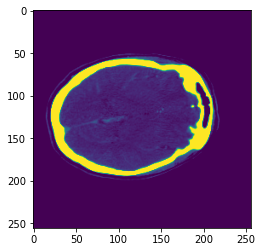

In [88]:
normalize(datalist[10]['ctpvals']).shape
plt.imshow(normalize(datalist[10]['ctpvals'])[:,:,0,15])

In [89]:
datalist[10]['image']

'/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_11/SMIR.Brain.XX.O.CT_4DPWI.345631/SMIR.Brain.XX.O.CT_4DPWI.345631.nii'

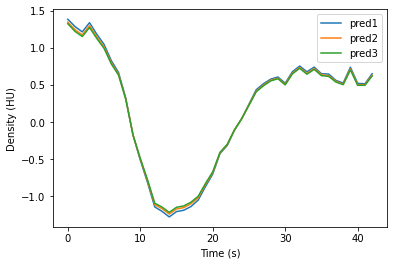

In [76]:
pred1 = model.predict(np.expand_dims(normalize(datalist[10]['ctpvals']), axis=0))[0]
pred2 = model.predict(np.expand_dims(normalize(datalist[20]['ctpvals']), axis=0))[0]
pred3 = model.predict(np.expand_dims(normalize(datalist[30]['ctpvals']), axis=0))[0]
plt.plot(pred1)
plt.plot(pred2)
plt.plot(pred3)
plt.legend(['pred1', 'pred2','pred3'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


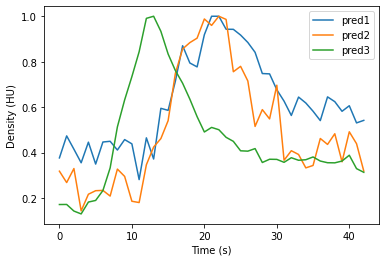

In [77]:
example_label_1 = normalize_aif(datalist[10]['label'])
example_label_2 = normalize_aif(datalist[20]['label'])
example_label_3 = normalize_aif(datalist[40]['label'])

plt.plot(example_label_1)
plt.plot(example_label_2)
plt.plot(example_label_3)
plt.legend(['pred1', 'pred2','pred3'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


In [11]:
train_generator = ISLES18DataGen(datalist,
    batch_size=1,
    minimum_number_volumes_ctp=43,
    input_size=(256, 256, None, 43),
    shuffle=True
)

In [12]:
sample = 3
X, y= train_generator[3]
example_aif = y[0]
example_vof = y[1]
plt.plot(example_aif)
plt.plot(example_vof)
plt.legend(['AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


TypeError: cannot unpack non-iterable NoneType object

In [49]:
path_checkpointer_model = ROOT_EXP +'results/' 
path_checkpointer_model += 'aifnet_2Pvol_' + str(initial_learning_rate)  + '.hdf5'
path_tensorboard_log    = ROOT_EXP + 'results/logsTensorBoard/'
path_tensorboard_log    += 'aifnet_2Pvol_' + str(initial_learning_rate) 

checkpointer = ModelCheckpoint(filepath=path_checkpointer_model, monitor='train_mean_absolute_error', verbose=1, save_best_only=True)
tb_callback = TensorBoard(log_dir=path_tensorboard_log, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [50]:
model.fit_generator(train_generator,epochs=5, callbacks=[checkpointer,tb_callback])

/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1935: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5


ValueError: in user code:

    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:850 train_function  *
        return step_function(self, iterator)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:840 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:833 run_step  **
        outputs = model.train_step(data)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:790 train_step
        y_pred = self(x, training=True)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv3d is incompatible with the layer: : expected min_ndim=5, found ndim=4. Full shape received: (None, None, None, None)


In [13]:
#Overfitting to one batch
for i in range(len(datalist)):    
    print("================= Next Sequence =================")
    print(str(i) + datalist[i%2]['image'])
    pct = read_nifti_file(datalist[i%2]['image'],min_num_sequence=43)
    volume = normalize(pct)
    example_label_aif = normalize_aif(datalist[i%2]['label'][0])
    example_label_vof = datalist[i%2]['label'][1]
    labels = np.array([example_label_vof,example_label_vof])
    print(volume.shape)
    print(example_label.shape)    
    #print(model.train_on_batch(x=volume[np.newaxis,:,:,:,:],y=example_label[np.newaxis,:]))
    print(model.train_on_batch(x=volume[np.newaxis,:,:,:,:],y=labels[np.newaxis,:,:]))

================= Next Sequence =================
0/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii
(256, 256, 8, 43)
(43,)
[63790.671875, 31901.04296875, 31889.626953125, 149.2745819091797, 149.27749633789062]
================= Next Sequence =================
1/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii
(256, 256, 8, 43)
(43,)
[6235.953125, 3118.36474609375, 3117.588623046875, 52.50442886352539, 52.50735855102539]
================= Next Sequence =================
2/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii
(256, 256, 8, 43)
(43,)
[63788.3046875, 31899.861328125, 31888.44140625, 149.27061462402344, 149.27354431152344]
================= Next Sequence =================
3/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Br

KeyboardInterrupt: 

In [11]:
np.sum(normalize_aif(example_label[np.newaxis,:]))

18.34008851303083

In [35]:
99%10

9

In [27]:
pred_aif = model.predict(np.expand_dims(normalize(read_nifti_file(datalist[15]['image'],min_num_sequence=43)), axis=0))[0]
pred_vof = model.predict(np.expand_dims(normalize(read_nifti_file(datalist[15]['image'],min_num_sequence=43)), axis=0))[1]

plt.plot(pred_aif[0])
plt.plot(pred_vof[0])
plt.legend(['pred_aif','pred_vof'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


IndexError: index 1 is out of bounds for axis 0 with size 1

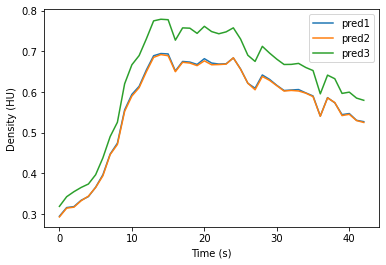

In [21]:
pred1 = model.predict(np.expand_dims(normalize(read_nifti_file(datalist[1]['image'],min_num_sequence=43)
                                      ), axis=0))[0]
pred2 = model.predict(np.expand_dims(normalize(read_nifti_file(datalist[20]['image'],min_num_sequence=43)
                                      ), axis=0))[0]
pred3 = model.predict(np.expand_dims(normalize(read_nifti_file(datalist[35]['image'],min_num_sequence=43)
                                      ), axis=0))[0]
plt.plot(pred1)
plt.plot(pred2)
plt.plot(pred3)
plt.legend(['pred1', 'pred2','pred3'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


In [29]:
pred1[0]

0.31633407

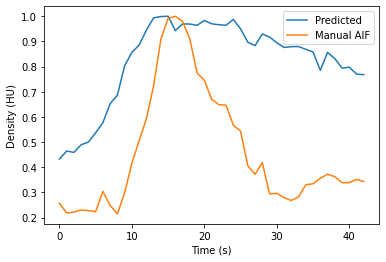

In [22]:
sample_prediction = 25
pct = read_nifti_file(datalist[sample_prediction]['image'],min_num_sequence=43)
volume = normalize(pct)
example_label = datalist[sample_prediction]['label'][0]

    
preds = model.predict(np.expand_dims(volume, axis=0))[0]

plt.plot(normalize_aif(preds))
plt.plot(normalize_aif(example_label))
plt.legend(['Predicted', 'Manual AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


In [ ]:
for key in cases_paths:
    example_pct = read_nifti_file(cases_paths[key],min_num_sequence=50)
    print(cases_paths[key])
    print(example_pct.shape)

In [21]:
min_intensity = 99999
max_intensity = 0
for i in range(len(datalist)):
    example_pct = read_nifti_file(datalist[i]['image'],min_num_sequence=43)
    example_label = datalist[i]['label'][0]
    print(example_pct.shape)
    print(example_label.shape)    
    print(example_label)
    cur_min = np.min(example_label)
    cur_max = np.max(example_label)
    if cur_min < min_intensity:
        min_intensity=cur_min
    if cur_max > max_intensity:
        max_intensity = cur_max
    print("min: " + str(np.min(example_label)) + ", max: " + str(np.max(example_label)) )
    print("==============================================================================")

(256, 256, 8, 43)
(43,)
[ 65.17546844  67.88008881  71.38324738  71.16088104  68.80565643
  50.76747894  70.0555954   73.96856689  72.30402374  85.19799042
  47.89317703  65.41912079  69.46140289  63.03180313  76.71797943
 117.90959167 122.22020721 200.00575256 296.57162476 321.24246216
 351.80267334 363.67218018 362.23324585 363.32443237 351.73028564
 320.06192017 253.75646973 227.79251099 206.17881775 190.67295837
 172.93933105 148.33799744 139.99394226 130.28613281 120.06873322
 132.34762573  96.75967407  93.7318573  109.64048767 108.80736542
  93.24468994  93.63285828 100.48235321]
min: 47.8931770324707, max: 363.67218017578125
(256, 256, 8, 43)
(43,)
[ 0.81714272 35.98949432 45.85534668 17.54782104 28.14332199 21.50254631
 35.77444839 25.98857689 43.35077286 58.03145599 66.22518921 64.56575775
 95.85170746 64.63071442 73.82795715 71.46063995 51.73550797 51.37894821
 63.41391754 81.02729797 46.18917847 47.25870895 46.13180923 24.24592018
 36.92317581 34.92689514 30.57113457 33.2344

(256, 256, 4, 43)
(43,)
[ 37.86141586  40.41308975  26.58592415  43.8094101   41.92656708
  40.32304764  48.56287766  44.08130264  36.48430634  43.59065628
  48.68935013  67.99256134  80.71238708  82.96593475  93.15247345
 116.7986145  128.24653625 128.68179321 135.5402832  126.6638031
 120.0774765   93.74198914  87.39208221  78.31151581  85.92312622
  73.22974396  75.25        61.33145142  55.70972824  59.97383499
  59.79750061  67.15567017  57.79601288  63.55825806  59.55962753
  69.2082901   59.08976746  59.56824112  50.88694382  48.68746567
  69.36468506  59.07564926  49.26641846]
min: 26.58592414855957, max: 135.540283203125
(256, 256, 2, 43)
(43,)
[33.3224678  38.12990952 26.95846176 28.60987663 28.18136024 37.76903152
 37.3178978  47.58279419 42.60303879 37.85522461 41.19854355 40.22006989
 34.60633469 26.15842056 40.75428009 45.10959244 37.46286774 40.20239258
 29.2206459  39.26128006 44.73703003 35.78829575 27.86134338 35.78214645
 42.27664948 42.82152176 43.30729675 41.606117

In [22]:
print(min_intensity)

0.8171427249908447


In [23]:
print(max_intensity)

363.67218017578125


In [24]:
datalist[8]['label'][0]

array([ 40.81223297,  26.76621246,  47.4235611 ,  21.57275391,
        20.12059784,  11.62003326,  44.75745392,  27.43131447,
        39.05145645,  52.44514084,  56.73603058,  85.44366455,
       117.57678986, 117.08487701, 132.81620789, 119.36367035,
       136.64447021, 142.52780151, 151.66877747, 131.69726562,
       127.2859726 , 101.61009216,  90.42941284,  75.46524048,
        81.56943512,  50.17470551,  61.61971283,  54.24238586,
        56.79148483,  49.6079483 ,  75.20306396,  54.2635231 ,
        41.79973602,  48.27097321,  46.26914215,  42.90690613,
        45.68405533,  43.54612732,  47.60110474,  30.71872139,
        43.51251984,  56.48103714,  33.98770905])

In [25]:
input_shape =(1, 256, 256, 8,43)
input_shape=input_shape[1:]
input_shape

(256, 256, 8, 43)

In [26]:
input_shape =(1, 256, 256, 8,43)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape[1:], data_format='channels_last')(x)
y.shape

TensorShape([1, 254, 254, 6, 64])

In [27]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [48]:
# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

NameError: name 'train_dataset' is not defined

In [49]:
model.inputs

[<KerasTensor: shape=(None, 256, 256, None, 43) dtype=float32 (created by layer 'input_10')>]

In [52]:
model.train_on_batch??

In [60]:
example_pct.shape

(256, 256, 8, 43)

In [62]:
example_pct[np.newaxis,:,:,:,:].shape

(1, 256, 256, 8, 43)

In [65]:
example_label[np.newaxis,:].shape

(1, 43)

In [67]:
layers.Conv3D??

In [ ]:
#The perfusion CT network will have input dimensions: [in_channels,out_channels,kernel_size]
# torch.nn.Conv3d(in_channels, out_channels, kernel_size, 
#stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)